In [104]:
import random
import math
import numpy as np

class Temperature:
    def __init__(self, f, parameters):
        self.updatefunction = f
        self.parameters = parameters
        self.current_temp = parameters["initial_temp"]
        self.iter = 1  # 初始化迭代计数器

    def update_temperature(self):
        """Method to update temperature"""
        self.current_temp = self.updatefunction(self.current_temp, self.iter, self.parameters)
        self.iter += 1
    
def Geometric_cooling(current_temp, iter, parameters):
    return current_temp * parameters["cooling_rate"]

def Basic_cooling(current_temp, iter, parameters):
    return parameters["a"] / np.log(iter + parameters["b"])

def calculate_total_distance(cities, route):
    """Calculate the total distance for a given route"""
    total_distance = 0
    number_of_cities = len(cities)

    for i in range(number_of_cities):
        # Calculate the distance between adjacent cities
        city1 = cities[route[i % number_of_cities]]
        city2 = cities[route[(i + 1) % number_of_cities]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance

    return total_distance

def two_opt_swap(route, i, k):
    """Applies 2-opt swapping on the given route between cities i and k"""
    new_route = route[0:i]
    new_route.extend(reversed(route[i:k + 1]))
    new_route.extend(route[k + 1:])
    return new_route

def simulated_annealing(cities, temperfuction, parameters):
    """Simulated annealing algorithm main function"""
    current_temp = parameters["initial_temp"]

    # Randomly initialize a solution (route)
    current_route = list(range(len(cities)))
    random.shuffle(current_route)

    current_distance = calculate_total_distance(cities, current_route)
    temper = Temperature(temperfuction, parameters)
    
    while temper.iter < parameters["max_iter"]:
        for _ in range(parameters["markov_chain_length"]):
            # Generate new solution
            i, k = sorted(random.sample(range(1, len(cities)), 2))
            new_route = two_opt_swap(current_route, i, k)
            city1, city2 = random.sample(range(len(cities)), 2)
            new_route[city1], new_route[city2] = new_route[city2], new_route[city1]

            new_distance = calculate_total_distance(cities, new_route)

            # Determine whether to accept the new solution
            if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temper.current_temp):
                current_route = new_route
                current_distance = new_distance
                
        temper.iter += 1
        temper.update_temperature()

    print(temper.iter)
    print(temper.current_temp)
    return current_route, current_distance

In [105]:
# First, read the uploaded file eil51.tsp.txt
file_path = 'plots/eil51.tsp.txt'

# Define a function to read TSP files and parse city coordinates
def read_tsp_file(file_path):
    cities = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append((float(parts[1]), float(parts[2])))
    return cities

# Call the function and read the city coordinates
cities = read_tsp_file(file_path)

In [106]:
initial_temp = 1000
cooling_rate = 0.99
max_iter = 10000
parameters_Geometric_cooling = {"initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":10, 
                                "cooling_rate": cooling_rate}

parameters_Basic_cooling = {"initial_temp" : initial_temp, 
                            "max_iter": max_iter,
                            "markov_chain_length":10, 
                            "a" : 10, 
                            "b" : 5}

cooling_functions = [
    (Geometric_cooling, parameters_Geometric_cooling),
    (Basic_cooling, parameters_Basic_cooling)
]

optimal_routes = []
optimal_distances = []
for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance = simulated_annealing(cities, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()  # 打印一个空行以分隔不同的输出

10001
1.499591560997956e-19
Optimal Route: [3, 41, 43, 39, 18, 40, 12, 24, 5, 13, 17, 46, 11, 4, 45, 50, 0, 21, 1, 19, 34, 35, 2, 27, 30, 25, 7, 6, 42, 23, 22, 47, 26, 31, 10, 37, 20, 28, 15, 49, 33, 29, 8, 48, 9, 38, 32, 44, 14, 36, 16]
Optimal Distance: 488.56336299616277

10001
1.085677281531147
Optimal Route: [47, 7, 25, 30, 27, 2, 35, 34, 19, 1, 15, 28, 20, 49, 29, 33, 8, 48, 9, 38, 32, 44, 14, 43, 16, 36, 11, 50, 45, 26, 21, 0, 31, 10, 37, 4, 41, 18, 39, 40, 12, 3, 46, 17, 24, 13, 23, 6, 42, 22, 5]
Optimal Distance: 474.50105692822393



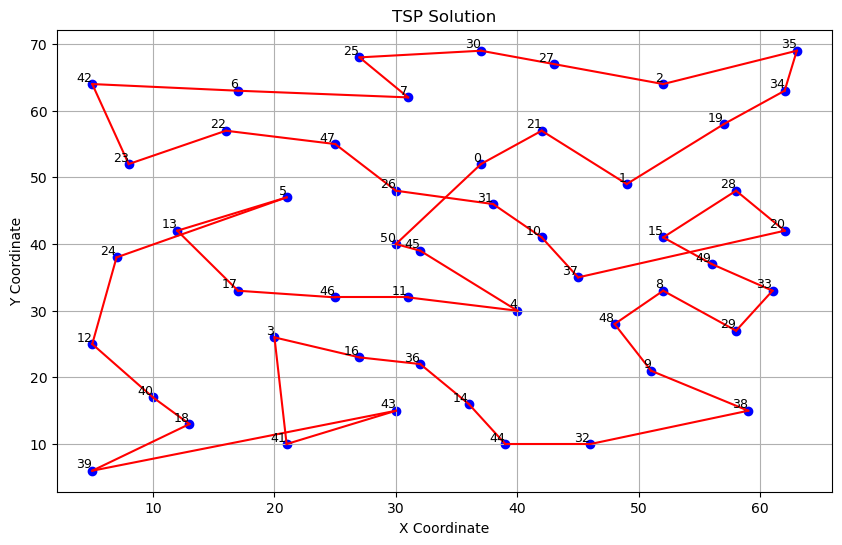

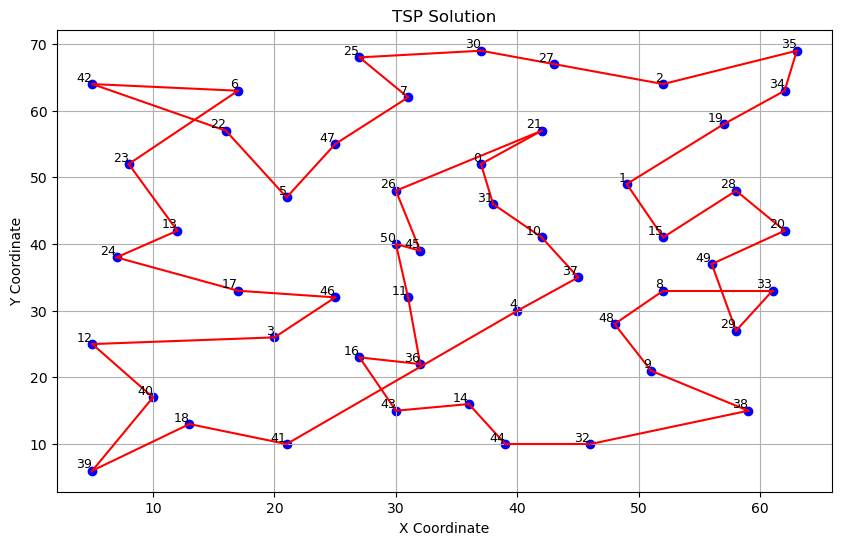

In [107]:
import matplotlib.pyplot as plt

def plot_tsp_solution(cities, route):
    """Drawing a solution to the traveling salesman problem"""
    plt.figure(figsize=(10, 6))

    # Extract and draw city coordinates
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.scatter(x, y, color='blue')

    #Add city label
    for i, city in enumerate(cities):
        plt.text(city[0], city[1], str(i), fontsize=9, ha='right', va='bottom')

    # Draw path
    for i in range(len(route)):
        start_city = cities[route[i]]
        end_city = cities[route[(i + 1) % len(route)]]
        plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], color='red')

    plt.title('TSP Solution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()
# Draw the solution using the optimal path and city coordinates found previously
for optimal_route in optimal_routes:
    plot_tsp_solution(cities, optimal_route)